In [1]:
#basics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Tools for accessing and reading data (you do not need to use all of them)
import os
import pathlib
import PIL
import cv2
import skimage 
from IPython.display import Image, display
from matplotlib.image import imread
import matplotlib.cm as cm

In [3]:
# Tensorflow basics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image

In [4]:
#Lime package for ML explainability
from lime import lime_image

# for reproducibility (does not guarantee fully reproducible results )
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

C:\Users\ashwi\anaconda3\envs\Proj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
dataset_path = "C:/Users/ashwi/0 Projects/casting_512x512"
data_dir = pathlib.Path(dataset_path)

In [10]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(f"Number of images: {image_count}")

Number of images: 1300


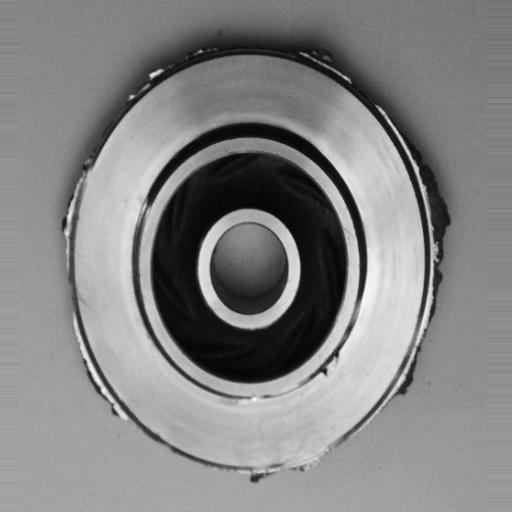

In [11]:
def_front = list(data_dir.glob('def_front/*'))
PIL.Image.open(def_front[0])

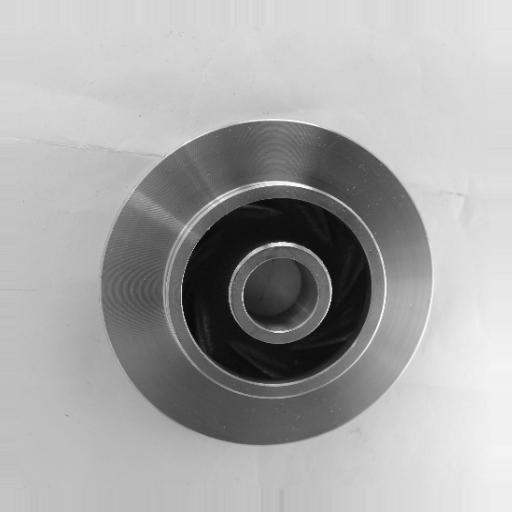

In [12]:
ok_front = list(data_dir.glob('ok_front/*'))
PIL.Image.open(ok_front[0])

In [13]:
sample1= imread(ok_front[0])
sample1.shape

(512, 512, 3)

In [28]:
batch_size = 64
epochs=50
img_height = 300
img_width = 300
img_size = (img_height, img_width)

In [16]:
train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    class_names =  ['ok_front', 'def_front'],
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1300 files belonging to 2 classes.
Using 975 files for training.


In [17]:
val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    class_names =  ['ok_front', 'def_front'],
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1300 files belonging to 2 classes.
Using 325 files for validation.


In [18]:
class_names = train_set.class_names
print(class_names)

['ok_front', 'def_front']


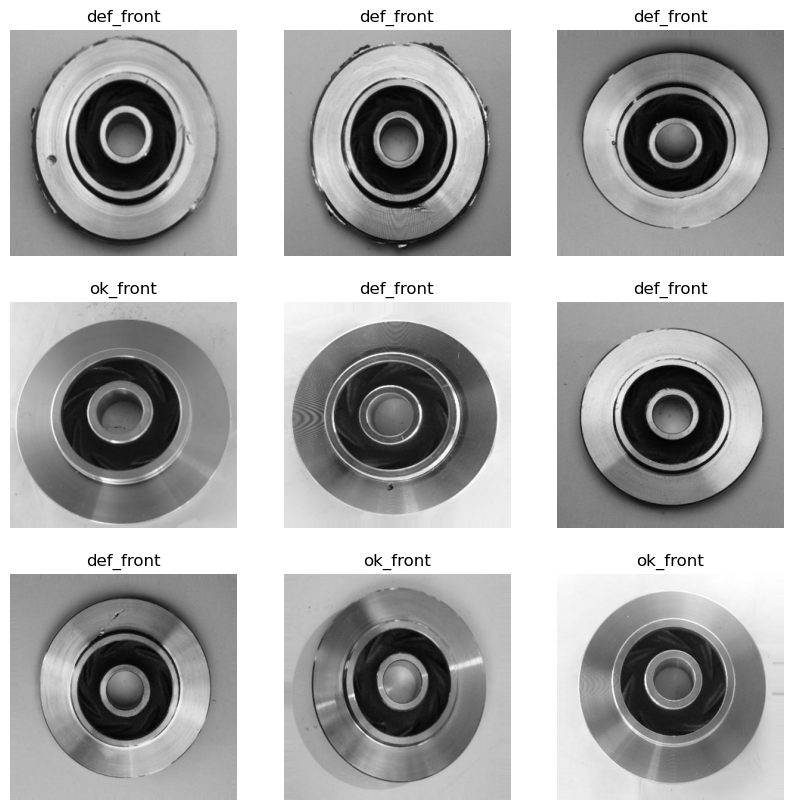

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
for images, labels in train_set:
  print(images.shape)
  print(labels.shape)
  break

(64, 300, 300, 3)
(64,)


In [21]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1300).prefetch(buffer_size=AUTOTUNE)
val_ds = val_set.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3), seed = seed ),
    layers.RandomZoom(0.1, seed = seed ),
    layers.RandomContrast(0.3, seed = seed  )
  ]
)

C:\Users\ashwi\anaconda3\envs\Proj\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
custom_model = Sequential([
    
  layers.Rescaling(1./255),
  data_augmentation,
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),


  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [24]:
custom_model.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

In [25]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') == 1.0 and logs.get('val_accuracy') == 1.0 :
            print("\nReached 100% accuracy so cancelling training!")
            self.model.stop_training = True

terminate_callback =  myCallback()

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1,min_delta=0.01,
                              patience=5, min_lr=0.000001)

In [29]:
history1 = custom_model.fit(train_ds, 
                            validation_data=val_ds, 
                            epochs=epochs,
                            callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8806 - loss: 0.2759 - val_accuracy: 0.8492 - val_loss: 0.3334 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8892 - loss: 0.2846 - val_accuracy: 0.9138 - val_loss: 0.2175 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9114 - loss: 0.2052 - val_accuracy: 0.9262 - val_loss: 0.2222 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9375 - loss: 0.1706 - val_accuracy: 0.8800 - val_loss: 0.3450 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8916 - loss: 0.2770 - val_accuracy: 0.9231 - val_loss: 0.2010 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9203 - loss: 0.1817 - val_accuracy: 0.9385 - val_loss: 0.1587 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9383 - loss: 0.1495 - val_accuracy: 

In [30]:
custom_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,264,421 (16.27 MB)

 Trainable params: 1,421,473 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,842,948 (10.84 MB)

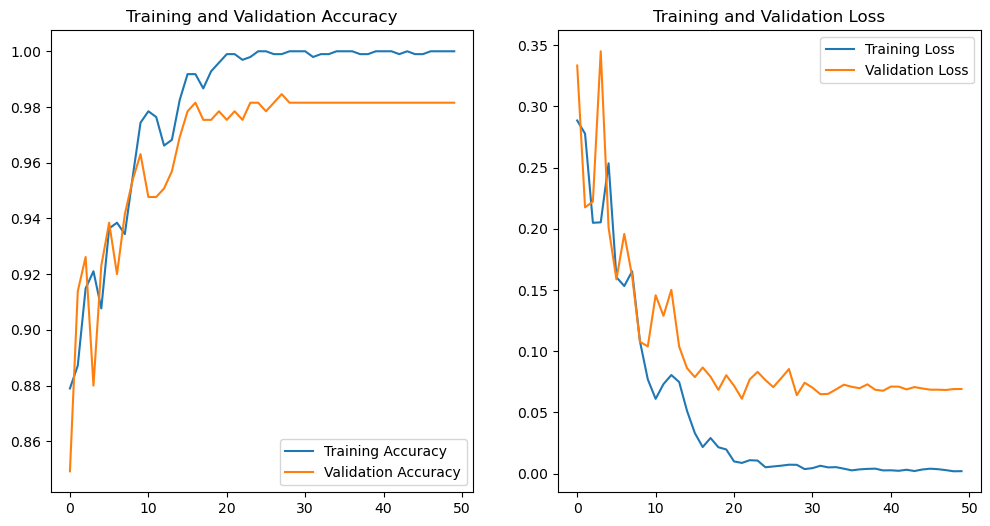

In [31]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [33]:
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))

x = data_augmentation(inputs)  # Apply random data augmentation

x = keras.layers.Rescaling(scale=1 / 255.0)(x)

x = base_model(x, training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
pretrained_model = keras.Model(inputs, outputs)

In [34]:
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
history2 = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.5822 - loss: 15.2672 - val_accuracy: 0.8800 - val_loss: 0.5097 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8671 - loss: 0.3734 - val_accuracy: 0.9446 - val_loss: 0.1439 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9772 - loss: 0.0953 - val_accuracy: 0.9538 - val_loss: 0.1112 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9841 - loss: 0.0356 - val_accuracy: 0.9846 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9932 - loss: 0.0254 - val_accuracy: 0.9877 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9898 - loss: 0.0184 - val_accuracy: 0.9815 - val_loss: 0.0429 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9984 - loss: 0.0116 - val_accuracy:

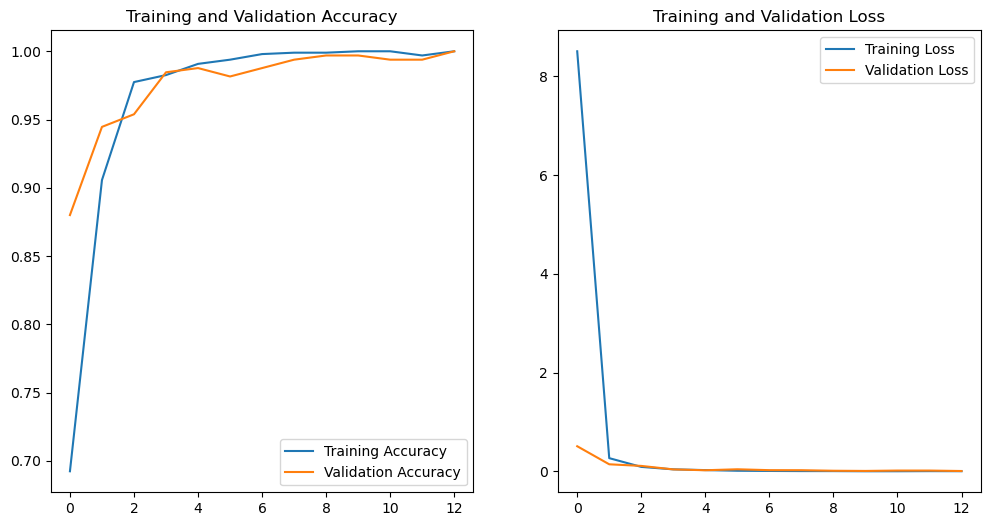

In [36]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
pretrained_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    26,214,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,505,453 (379.58 MB)

 Trainable params: 26,214,657 (100.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 52,429,316 (200.00 MB)

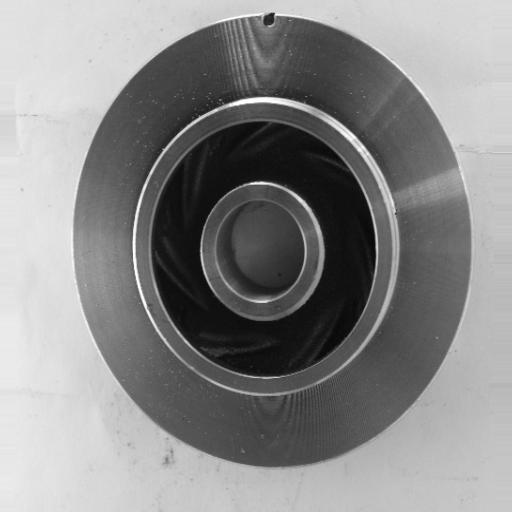

In [43]:
# The path to our target image
img_path = 'C:/Users/ashwi/0 Projects/casting_512x512/def_front/cast_def_0_238.jpeg'  # Adjust the path as needed
display(Image(img_path))

In [44]:
def get_img_array(img_path, size):
    # `Sİze of image 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [45]:
images = get_img_array(img_path, img_size)
preds = pretrained_model.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


In [46]:
if prediction == 1:
    print("ok")
else:
    print("not_ok")
    
print(pct)

not_ok
0.99177897


In [47]:
model_builder = keras.applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
last_conv_layer_name = "block14_sepconv2_act"

In [48]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [51]:
explainer = lime_image.LimeImageExplainer()

In [52]:
explanation = explainer.explain_instance(images[0].astype('double'), custom_model.predict, 
                                        top_labels=2, hide_color=0, num_samples=300)

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  3%|▎         | 10/300 [00:00<00:06, 41.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  7%|▋         | 20/300 [00:00<00:05, 54.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 10%|█         | 30/300 [00:00<00:04, 59.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 13%|█▎        | 40/300 [00:00<00:04, 64.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 17%|█▋        | 50/300 [00:00<00:03, 65.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 20%|██        | 60/300 [00:00<00:03, 66.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 23%|██▎       | 70/300 [00:01<00:03, 67.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 27%|██▋       | 80/300 [00:01<00:03, 68.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 30%|███       | 90/300 [00:01<00:03, 69.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 33%|███▎      | 100/300 [00:01<00:02, 69.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 37%|███▋      | 110/300 [00:01<00:02, 69.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 40%|████      | 120/300 [00:01<00:02, 70.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 43%|████▎     | 130/300 [00:01<00:02, 70.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 47%|████▋     | 140/300 [00:02<00:02, 70.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 50%|█████     | 150/300 [00:02<00:02, 70.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 53%|█████▎    | 160/300 [00:02<00:02, 68.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 57%|█████▋    | 170/300 [00:02<00:01, 69.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 60%|██████    | 180/300 [00:02<00:01, 69.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 63%|██████▎   | 190/300 [00:02<00:01, 70.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 67%|██████▋   | 200/300 [00:02<00:01, 71.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 70%|███████   | 210/300 [00:03<00:01, 70.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 73%|███████▎  | 220/300 [00:03<00:01, 69.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 77%|███████▋  | 230/300 [00:03<00:00, 70.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 80%|████████  | 240/300 [00:03<00:00, 69.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 83%|████████▎ | 250/300 [00:03<00:00, 69.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 87%|████████▋ | 260/300 [00:03<00:00, 71.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 90%|█████████ | 270/300 [00:03<00:00, 72.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 93%|█████████▎| 280/300 [00:04<00:00, 73.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 97%|█████████▋| 290/300 [00:04<00:00, 73.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


100%|██████████| 300/300 [00:04<00:00, 69.26it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


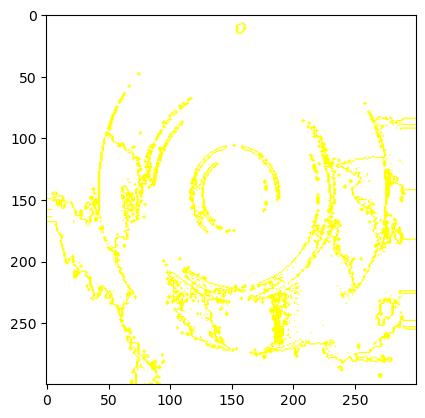

In [53]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=False)

plt.imshow(mark_boundaries(temp_1, mask_1))